# Driver Drowsiness Detection Model

### Dependencies

    1. Tensorflow
    2. OpenCV
    3. Matplotlib
    4. NumPy

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

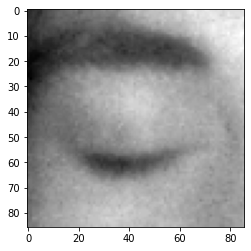

In [3]:
imgs = cv2.imread("train_small/closed_eyes/s0001_00075_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(imgs, cmap="gray")

In [4]:
imgs.shape

(86, 86)

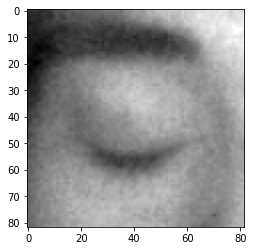

In [5]:
Data_Dir = "train_mid"
classes = ["closed_eyes", "open_eyes"]
for category in classes:
    path = os.path.join(Data_Dir, category)
    for img in os.listdir(path):
        imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
        plt.imshow(imgs, cmap="gray")
        plt.show()
        break
    break

### Resizing all images in dataset
( since MobileNet uses images of size 224x224 and our images have size 86x86 )

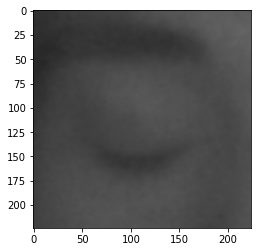

In [6]:
img_size = 224

new_img_arr = cv2.resize(col_reset, (img_size, img_size))
plt.imshow(new_img_arr, cmap="gray")
plt.show()

### Reading all images into an array to label

In [7]:
training_data = []

def create_train_data():
    for category in classes:
        path = os.path.join(Data_Dir, category)
        class_num = classes.index(category)   #either 0, 1
        for img in os.listdir(path):
            try:
                imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
                new_img_arr = cv2.resize(col_reset, (img_size, img_size))
                training_data.append([new_img_arr, class_num])
            except Exception as e:
                pass

In [8]:
create_train_data()

In [9]:
print(len(training_data))

20000


### Shuffling randomly to prevent overfitting

In [10]:
import random

random.shuffle(training_data)

### Dividing training data into features and labels

In [11]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [12]:
X.shape

(20000, 224, 224, 3)

### Normalize

In [13]:
X = X/255.0

Dividing by 255 because there are 255 values in rgb specturm 

In [14]:
y = np.array(y)

### Saving Features and Labels into X and Y

In [15]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [16]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

### Transfer Learning Model Traininig

Using <u>MobileNet</u> Deep Learning model to as our base model to train with our dataset and classify the images into **0 and 1 (open and closed eyes)**.

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
model = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
model.summary()

In [19]:
base_input = model.layers[0].input ## gets the base layer

In [20]:
base_output = model.layers[-4].output ## ignoring the last 3 layers to make our own layers

In [21]:
Flat_layer = layers.Flatten()(base_output)
final_out = layers.Dense(1)(Flat_layer)    ## one node (either 0/1)
final_out = layers.Activation('sigmoid')(final_out)    ##Using the model with SIGMOID Activation Function as we are performing

In [22]:
new_model = keras.Model(inputs = base_input, outputs = final_out)

In [ ]:
new_model.summary()

### Last 3 layers changed with the final_out

## Settings for Binary Classificaation

In [23]:
new_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
new_model.fit(X, y, epochs=10, validation_split=0.1)

Epoch 1/10
563/563 [==============================] - 681s 1s/step - loss: 0.0810 - accuracy: 0.9734 - val_loss: 0.0833 - val_accuracy: 0.9755
Epoch 2/10
563/563 [==============================] - 665s 1s/step - loss: 0.0362 - accuracy: 0.9862 - val_loss: 0.0411 - val_accuracy: 0.9835
Epoch 3/10
563/563 [==============================] - 676s 1s/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.0501 - val_accuracy: 0.9870
Epoch 4/10
563/563 [==============================] - 667s 1s/step - loss: 0.0324 - accuracy: 0.9880 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 5/10
563/563 [==============================] - 669s 1s/step - loss: 0.0238 - accuracy: 0.9911 - val_loss: 0.0689 - val_accuracy: 0.9805
Epoch 6/10
563/563 [==============================] - 667s 1s/step - loss: 0.0257 - accuracy: 0.9911 - val_loss: 0.0440 - val_accuracy: 0.9900
Epoch 7/10
563/563 [==============================] - 665s 1s/step - loss: 0.0223 - accuracy: 0.9918 - val_loss: 0.0458 - val_accuracy: 0.9870

In [25]:
new_model.save('ddet_v2.h5')

### Loading pre-trained ddet_model.h5, so that no need to train again
* ddet_model trained for 5 epochs on 5000 images (validation accuracy = 98.20)
* ddet_v2 trained for 10 epochs on 20000 images (validation accuracy = 99.15)
#### Models saved so that no need to train again for evey use 

In [2]:
new_model = tf.keras.models.load_model('ddet_v2.h5')

### Checking Predictions


In [3]:
img_size = 224
def predictor(pathh):
    imgs = cv2.imread(pathh, cv2.IMREAD_GRAYSCALE)
    col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
    new_array = cv2.resize(col_reset, (img_size, img_size))
    plt.imshow(new_array)
    X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
    X_input.shape
    X_input = X_input/255.0 
    predictions = new_model.predict(X_input)
    print(predictions)

#### 1. Open Eyes

[[0.9559243]]


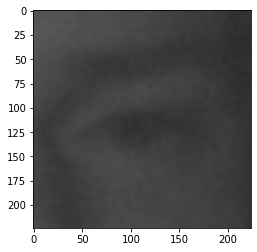

In [4]:
predictor('train_small/open_eyes/s0005_00726_0_0_1_0_0_01.png')

[[0.9999556]]


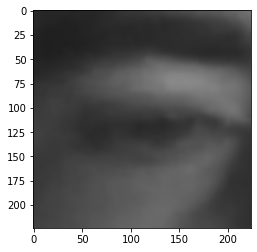

In [5]:
predictor('train_small/open_eyes/s0012_05727_0_0_1_0_0_03.png')

#### 2. Closed Eyes

[[0.0010547]]


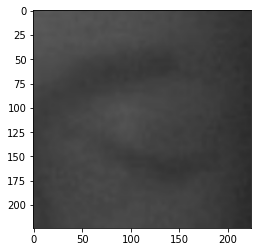

In [6]:
predictor('train_small/closed_eyes/s0002_00727_0_0_0_0_0_01.png')

[[0.00011017]]


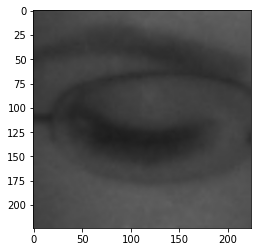

In [7]:
predictor('train_small/closed_eyes/s0037_05888_1_1_0_0_0_01.png')

### Pattern Recognized:
    1. For images with open eyes, prediction value is > 0.9
    2. For images with closed eyes, the prediction value is close to < 0.1

# **Live Video Feed Implementation**

In [8]:
import winsound

frequency = 2000
duration = 1000

In [ ]:
font = cv2.FONT_HERSHEY_PLAIN

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")


cap = cv2.VideoCapture(0) #the argument in VideoCapture() refers to the video capture device number configured

ctr = 0    #time counter for rasising alert

while True:
    ret, frame = cap.read()
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    for(x, y, w, h) in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        eyes_2 = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes_2) == 0:
            print("Eyes not Detected")
        else:
            for(ex, ey, ew, eh) in eyes_2:
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
                
    final_roi_img = cv2.resize(eyes_roi, (224, 224))
    final_roi_img = np.expand_dims(final_roi_img, axis = 0)
    # adding another dimension as the model requires 4 dimensions, for eg (img.shape -> (1, 224, 224, 3))
    final_roi_img = final_roi_img/255.0        #normalising
    
    predictions = new_model.predict(final_roi_img)
    print(predictions)
    if(predictions > 0.8):
        status = "Eyes Open"
        
        #Inserting text on video
        x1, y1, w1, h1 = 0, 0, 175, 175
        cv2.putText(frame, status, (100,100), font, 5, (0,0,255), 2, cv2.LINE_8)
        
    else:
        ctr += 1
        status = "Eyes Closed"
        
        #Inserting text on video
        x1, y1, w1, h1 = 0, 0, 175, 175
        cv2.putText(frame, status, (100,100), font, 5, (0,0,255), 2, cv2.LINE_8)
        
        if ctr > 5:
            cv2.putText(frame, status, (100,100), font, 5, (0,0,255), 2, cv2.LINE_8)
            winsound.Beep(frequency, duration)
            ctr = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(face_cascade.empty())
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # drawing rectangle around eyes

    for(x, y, w, h) in eyes:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2) 
    
    cv2.imshow("Drowsiness Detection", frame)
    
    #exiting the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()    